### Model Info: loss: 0.2088 - accuracy: 0.9192 - val_loss: 0.1316 - val_accuracy: 0.9568
Data: Grid

ImageDataGenerator( \
    rescale=1. / 255, \
    shear_range=0.2, \
    zoom_range=0.2, \
    horizontal_flip=True)
   
batch_size = 64 \
image_width = 224 \
image_height = 224 
    
optimizer='rmsprop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime, os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [2]:
# image dataset from directory

In [6]:
train_path = 'grid_wildfire_smoke/train'
test_path = 'grid_wildfire_smoke/test'

In [7]:
#apply image augmentation
train_image_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
"""ImageDataGenerator(
    rescale=1./255)"""
    
test_image_generator = ImageDataGenerator(rescale=1./255)

In [10]:
# Variables for model
batch_size = 64
image_width = 224 
image_height = 224 
classes = ['no_smoke','smoke']
color_mode="rgb"
IMAGE_WIDTH_HEIGHT = (image_width, image_height)

class_mode = 'binary'

#create train data generator flowing from train_input_folder
train_generator = train_image_generator.flow_from_directory(
            train_path,
            target_size=IMAGE_WIDTH_HEIGHT,
            batch_size=batch_size,
            classes=classes,
            color_mode=color_mode,
            class_mode=class_mode)
            
#create validation data generator flowing from test_input_folder
test_generator = test_image_generator.flow_from_directory(
        test_path,
        target_size=IMAGE_WIDTH_HEIGHT,
        batch_size=batch_size,
        classes=classes,
        color_mode=color_mode,
        class_mode=class_mode)

Found 2502 images belonging to 2 classes.
Found 2468 images belonging to 2 classes.


In [11]:
# img_input = layers.Input(shape=(image_width, image_height, 3))
input_shape = (image_width, image_height, 3)

In [12]:
model = Sequential()
model.add(Conv2D(32, 
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# output layer - binary // sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


2022-04-06 00:53:03.725608: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
epochs = 10
steps_per_epoch = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator,
      validation_steps=test_steps,
      epochs=epochs,
      callbacks=[tensorboard_callback])

Epoch 1/10
39/39 [==============================] - 95s 2s/step - loss: 0.9277 - accuracy: 0.6612 - val_loss: 0.4438 - val_accuracy: 0.8458
Epoch 2/10
39/39 [==============================] - 92s 2s/step - loss: 0.4668 - accuracy: 0.7777 - val_loss: 0.4704 - val_accuracy: 0.7677
Epoch 3/10
39/39 [==============================] - 92s 2s/step - loss: 0.4449 - accuracy: 0.8290 - val_loss: 0.2766 - val_accuracy: 0.8865
Epoch 4/10
39/39 [==============================] - 92s 2s/step - loss: 0.3606 - accuracy: 0.8372 - val_loss: 0.2837 - val_accuracy: 0.8873
Epoch 5/10
39/39 [==============================] - 92s 2s/step - loss: 0.3312 - accuracy: 0.8655 - val_loss: 0.2257 - val_accuracy: 0.9071
Epoch 6/10
39/39 [==============================] - 92s 2s/step - loss: 0.2805 - accuracy: 0.8819 - val_loss: 0.3674 - val_accuracy: 0.8462
Epoch 7/10
39/39 [==============================] - 91s 2s/step - loss: 0.2582 - accuracy: 0.8999 - val_loss: 0.2971 - val_accuracy: 0.8997
Epoch 8/10
39/39 [==

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                    

Text(0.5, 0, 'epoch')

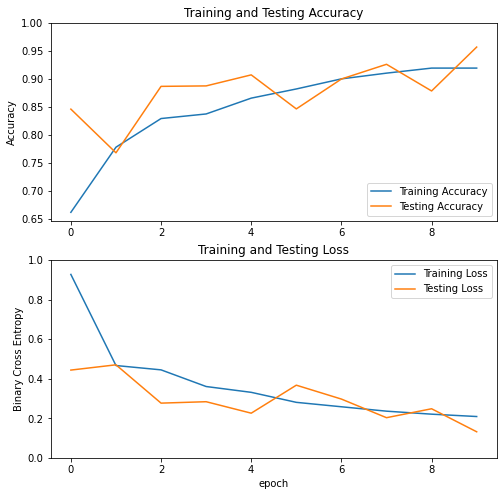

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Testing Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Testing Loss')
plt.xlabel('epoch')